In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
train = pd.read_csv('predict-student-performance-from-game-play/train.csv')

In [4]:
def df_scale(train):
    train.drop(['fullscreen','hq','music','screen_coor_x','screen_coor_y','name','text'], axis=1, inplace=True)
    train['room_coor_x'].fillna(0, inplace = True)
    train['room_coor_y'].fillna(0, inplace=True)
    train['hover_duration'].fillna(0, inplace=True)
    train['page'].fillna(-1, inplace=True)
    train['fqid'].fillna(-1,  inplace=True).astype('category')
    train['text_fqid'].fillna(-1,  inplace=True).astype('category')
    return train

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

items = train['page'].values
labels = items.reshape(-1,1)

oh_encoder = OneHotEncoder()


oh_encoder.fit(labels)
oh_labels = oh_encoder.transform(labels)

train_cat = oh_labels.toarray()

tmp_df = pd.DataFrame(train_cat, columns=['page_' + str(col) for col in range(-1,7)])
train = pd.concat([train.drop(columns=['page'],axis=1),tmp_df],axis=1)

In [6]:
lb_encoder = LabelEncoder()

lb_items = train['fqid'].values
lb_labels = items.reshape(-1, 1)
lb_encoder.fit(lb_labels)
lb_labels_transform = lb_encoder.transform(lb_labels)
train['fqid'] = lb_labels_transform


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [7]:
lb_encoder = LabelEncoder()

lb_items = train['text_fqid'].values
lb_labels = items.reshape(-1, 1)
lb_encoder.fit(lb_labels)
lb_labels_transform = lb_encoder.transform(lb_labels)
train['text_fqid'] = lb_labels_transform


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [8]:
targets = pd.read_csv('predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [20]:
OBJECT = ['event_name', 'room_fqid']
NUMS = ['elapsed_time', 'room_coor_x',
        'level', 'room_coor_y', 'hover_duration']

EVENTS = ['navigate_click', 'person_click', 'cutscene_click', 'object_click',
          'map_hover', 'notification_click', 'map_click', 'observation_click',
          'checkpoint']

PAGE = ['page_-1', 'page_0', 'page_1', 'page_2',
        'page_3', 'page_4', 'page_5', 'page_6']
FQID = ['fqid']
# FQID = ['fqid' + str(col) for col in range(128)]
TEXT_FQID = ['text_fqid']

In [21]:
def feature_engineer(train):

    dfs = []
    for c in OBJECT:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    # for c in NUMS:
    #     tmp = train.groupby(['session_id', 'level_group'])[c].agg('std')
    #     tmp.name = tmp.name + '_std'
    #     dfs.append(tmp)
    for c in PAGE:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in FQID:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in TEXT_FQID:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('n_unique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in EVENTS:
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS, axis=1)

    df = pd.concat(dfs, axis=1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df


In [22]:
%%time
df = feature_engineer(train)
print(df.shape)

(35337, 28)
CPU times: user 21.7 s, sys: 2.82 s, total: 24.5 s
Wall time: 25 s


In [23]:
FEATURES = df.columns[1:]
print(f'{len(FEATURES)}개의 특성')
ALL_USERS = df.index.unique()
print(f'{len(ALL_USERS)}명의 유저 정보')

27개의 특성
11779명의 유저 정보


/var/folders/s0/5rhprztj2xs1kzwd87bwg_y00000gn/T/ipykernel_57095/1751860701.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  co_df = df.corr()
/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


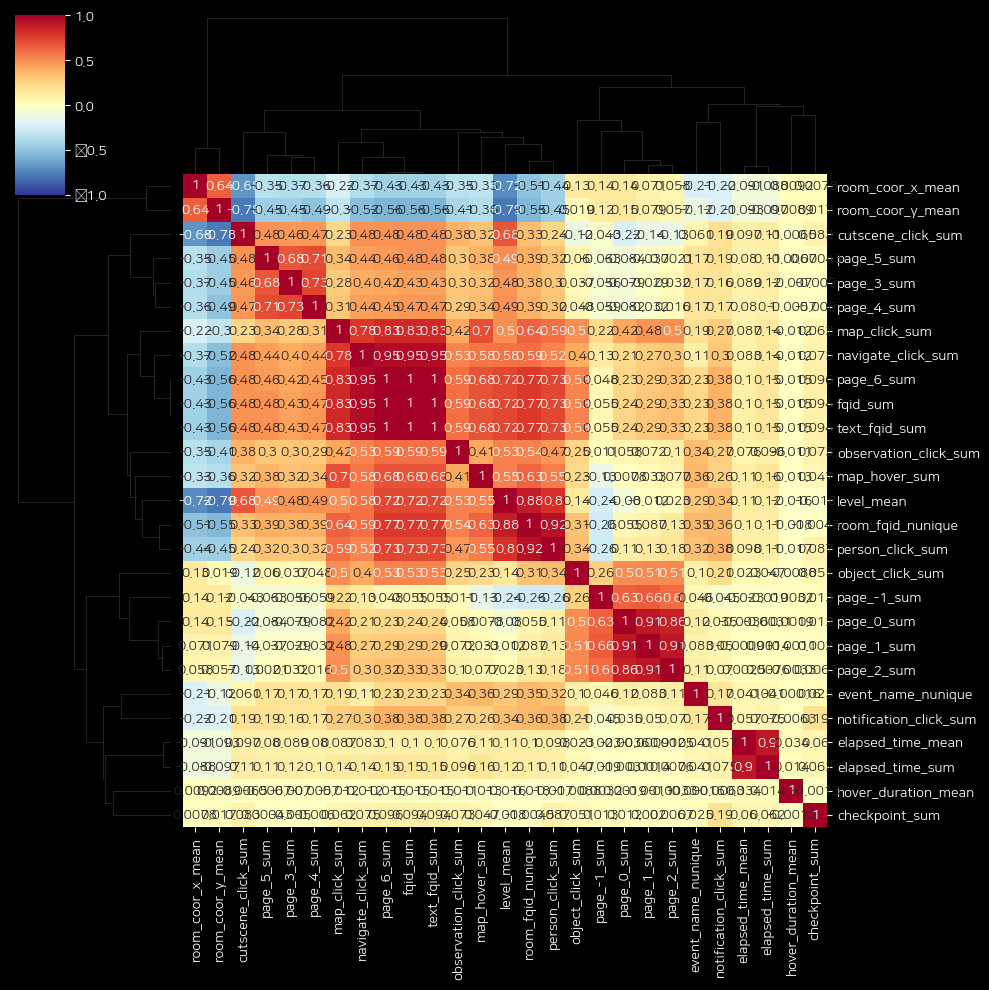

In [24]:
co_df = df.corr()

sns.clustermap(co_df,
               annot=True,      # 실제 값 화면에 나타내기
               cmap='RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin=-1, vmax=1,  # 컬러차트 -1 ~ 1 범위로 표시
               )


/var/folders/s0/5rhprztj2xs1kzwd87bwg_y00000gn/T/ipykernel_57095/3004839341.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  co_df = df.corr()
/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


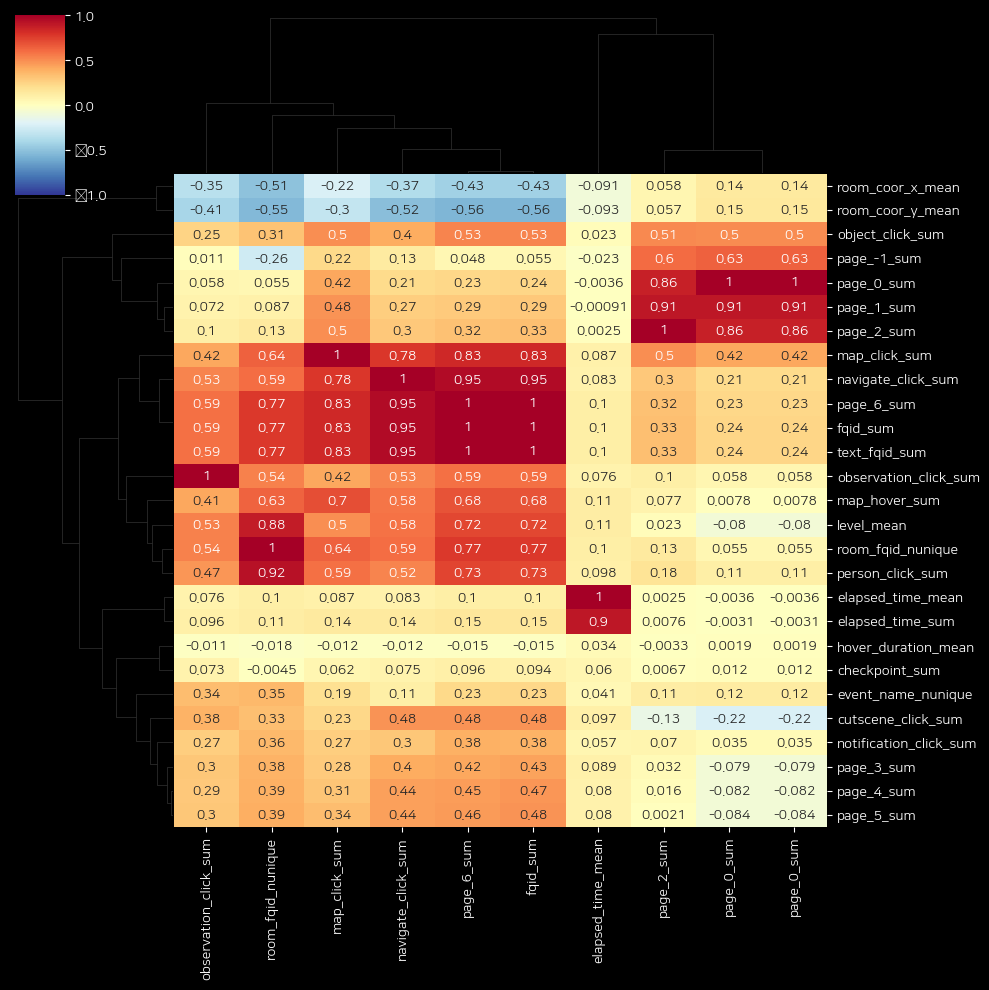

In [36]:
co_df = df.corr()
tg = co_df[['observation_click_sum', 'page_0_sum', 'page_2_sum', 'map_click_sum',
            'navigate_click_sum',
            'page_6_sum',
            'fqid_sum',
            'room_fqid_nunique',
            'page_0_sum',
            'elapsed_time_mean']]

sns.clustermap(co_df[['observation_click_sum', 'page_0_sum', 'page_2_sum', 'map_click_sum',
                      'navigate_click_sum',
                      'page_6_sum',
                      'fqid_sum',
                      'room_fqid_nunique',
                      'page_0_sum',
                      'elapsed_time_mean']],
               annot=True,      # 실제 값 화면에 나타내기
               cmap='RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin=-1, vmax=1,  # 컬러차트 -1 ~ 1 범위로 표시
               )


<AxesSubplot: >

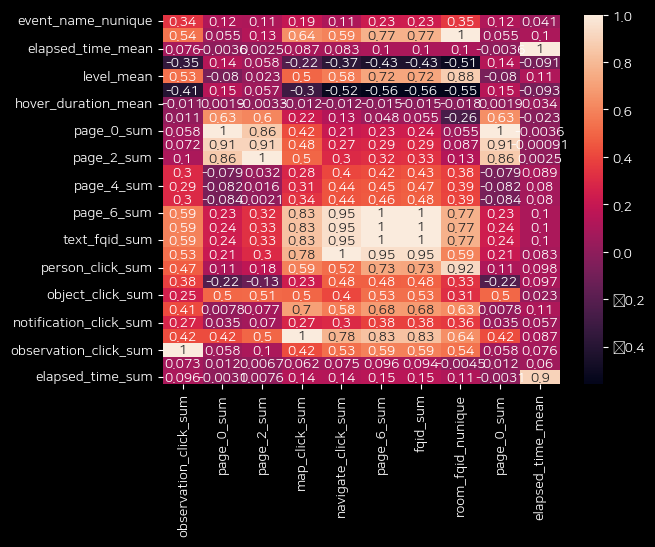

In [37]:
sns.heatmap(tg, annot=True)


In [31]:
co_df[['observation_click_sum', 'page_0_sum', 'page_2_sum']]


,observation_click_sum,page_0_sum,page_2_sum
event_name_nunique,0.340978,0.120069,0.109404
room_fqid_nunique,0.537940,0.054575,0.134417
elapsed_time_mean,0.076230,-0.003607,0.002478
room_coor_x_mean,-0.349185,0.138374,0.057600
level_mean,0.532624,-0.080361,0.023267
room_coor_y_mean,-0.409485,0.146834,0.057420
hover_duration_mean,-0.010853,0.001866,-0.003298
page_-1_sum,0.011064,0.634867,0.604897
page_0_sum,0.058332,1.000000,0.860833
page_1_sum,0.072139,0.906143,0.905609


In [211]:
gkf = GroupKFold(n_splits=20)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print(' ')
    print('Fold', i+1)
    print(' ')

    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.05,
        'max_depth': 4,
        'n_estimators': 1500,
        'early_stopping_rounds': 50,
        'tree_method': 'hist',
        'subsample': 0.8,
        'colsample_bytree': 0.4,
        }

    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1, 19):

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t <= 3:
            grp = '0-4'
        elif t <= 13:
            grp = '5-12'
        elif t <= 22:
            grp = '13-22'

        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == t].set_index(
            'session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == t].set_index(
            'session').loc[valid_users]

        # TRAIN MODEL
        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype(
                    'float32'), valid_y['correct'])],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ', end='')

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t -
                1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:, 1]

    print()


 
Fold 1
 
1(196), 2(134), 3(120), 4(165), 5(133), 6(99), 7(176), 8(46), 9(110), 10(193), 11(87), 12(58), 13(164), 14(66), 15(149), 16(77), 17(83), 18(213), 
 
Fold 2
 
1(126), 2(80), 3(68), 4(140), 5(80), 6(227), 7(167), 8(87), 9(79), 10(147), 11(69), 12(125), 13(80), 14(162), 15(92), 16(46), 17(42), 18(137), 
 
Fold 3
 
1(133), 2(74), 3(60), 4(355), 5(31), 6(100), 7(165), 8(39), 9(75), 10(54), 11(116), 12(76), 13(126), 14(70), 15(63), 16(94), 17(124), 18(187), 
 
Fold 4
 
1(82), 2(117), 3(100), 4(145), 5(126), 6(167), 7(206), 8(81), 9(34), 10(78), 11(109), 12(72), 13(84), 14(136), 15(151), 16(45), 17(52), 18(110), 
 
Fold 5
 
1(147), 2(96), 3(118), 4(181), 5(247), 6(91), 7(106), 8(53), 9(210), 10(117), 11(107), 12(135), 13(121), 14(207), 15(289), 16(67), 17(113), 18(77), 
 
Fold 6
 
1(124), 2(102), 3(97), 4(136), 5(156), 6(144), 7(69), 8(56), 9(113), 10(161), 11(87), 12(103), 13(144), 14(158), 15(197), 16(85), 17(69), 18(107), 
 
Fold 7
 
1(124), 2(162), 3(151), 4(132), 5(152), 6(96)

In [212]:
# True 레이블을 18개의 열로 구성된 데이터 프레임에 넣습니다
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [213]:
# 확률을 1과 0으로 변환하기 위한 최적의 임계값을 찾습니다
scores = []
thresholds = []
best_score = 0
best_threshold = 0

for threshold in np.arange(0.4, 0.81, 0.01):
    preds = (oof.values.reshape((-1)) > threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_score:
        best_score = m
        best_threshold = threshold
print(f'Best 임계점: {best_threshold:.2f}')
print(f'Best F1_score: {best_score:.4f}')


Best 임계점: 0.62
Best F1_score: 0.6790


In [82]:
del train
del df
del oof
del targets

In [21]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi


In [22]:
api = KaggleApi()


In [23]:
api.authenticate()

In [180]:
sample_submission = pd.read_csv("predict-student-performance-from-game-play/sample_submission.csv")
test = pd.read_csv("predict-student-performance-from-game-play/test.csv")


In [181]:
limits = {'0-4': (1, 4), '5-12': (5, 14), '13-22': (14, 19)}


test = df_scale(test)

items = test['page'].values
labels = items.reshape(-1, 1)

oh_labels = oh_encoder.transform(labels)

train_cat = oh_labels.toarray()

tmp_df = pd.DataFrame(train_cat, columns=['page_' + str(col) for col in range(-1, 7)])
test = pd.concat([test.drop(columns=['page'], axis=1), tmp_df], axis=1)

    # FEATURE ENGINEER TEST DATA
df = feature_engineer(test)



32

In [169]:
# grp = test.level_group.values[0]
# a, b = limits[grp]
# for t in range(a, b):
#     clf = models[f'{grp}_{t}']
#     p = clf.predict_proba(df[FEATURES].astype('float32'))[:, 1]
#     mask = sample_submission.session_id.str.contains(f'q{t}')
#     print(mask)
#     sample_submission.loc[mask, 'correct'] = int(p.item() > best_threshold)

# # clf.predict(sample_submission)


0

In [179]:
df[FEATURES]


,event_name_nunique,room_fqid_nunique,fqid_nunique,elapsed_time_mean,room_coor_x_mean,level_mean,room_coor_y_mean,hover_duration_mean,elapsed_time_std,room_coor_x_std,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090109393214576,11,6,24,1.171198e+05,39.449107,2.050000,-64.625451,2006.800000,6.661989e+04,440.144543,...,62,21,27,9,2,5,3,3,1,16396773
20090109393214576,11,12,52,6.165666e+06,-124.577142,17.918089,-220.648267,973.864865,2.277512e+05,629.713345,...,240,137,78,40,20,10,7,4,1,3613080500
20090109393214576,11,12,43,2.092368e+06,48.260390,7.686567,-43.350532,2301.315789,2.124842e+06,378.100318,...,130,127,11,175,17,9,6,2,1,1121509230
20090312143683264,11,7,27,1.424183e+05,91.577137,1.803681,-112.486741,3066.555556,7.825763e+04,440.053605,...,62,18,33,22,2,9,2,4,1,23214178
20090312143683264,11,15,55,2.195108e+06,-21.133174,17.335626,-198.835547,864.096154,3.078757e+05,576.561514,...,414,113,55,37,31,8,12,5,1,1595843559
20090312143683264,11,13,56,7.911504e+05,42.823079,8.445172,-78.412808,1379.492958,2.456884e+05,414.653052,...,276,102,16,92,22,9,13,8,1,483392868
20090312331414616,11,6,23,1.128328e+05,67.333464,1.861538,-61.571970,2176.818182,6.100448e+04,431.739627,...,41,19,30,10,4,6,2,1,1,14668268
20090312331414616,11,13,62,1.262481e+06,-93.299934,18.332689,-156.284179,794.542373,1.934719e+05,575.032012,...,202,102,55,50,26,11,9,6,1,652702482
20090312331414616,11,11,46,5.585205e+05,8.512538,8.459119,-70.478232,1561.096154,1.366002e+05,357.487622,...,92,97,11,36,25,9,7,1,1,177609534


In [172]:
counter = 0
# The API will deliver two dataframes in this specific order,
# for every session+level grouping (one group per session for each checkpoint)
# if counter==0:
#     display(sample_submission.head())
#     display(test.head())
#     print(test.shape)
best = best_threshold # best_threshold는 상수 

print(best)
p = clf.predict_proba(df[FEATURES].astype('float32'))[:, 1] # df. = feature engineer 돌린 test
print(p) # 리스트  # 사람 3 문제 54 인당 18개 ? 사람 3명 3그룹 9 


0.6200000000000002
[0.80293745 0.2460512  0.53370196 0.63770825 0.18540768 0.32812896
 0.828757   0.30069208 0.41950473]


In [174]:
# users make predictions here using the test data
for index, row in sample_submission.iterrows():
    print(f"index = {index}, row = {row}")
    q = int(row['session_id'].split('_')[-1][1:])

    # if p.item() > best.item():
    #     sample_submission.loc[index, 'correct'] = True
    # else:
    #     sample_submission.loc[index, 'correct'] = False
    # sample_submission.loc[index, 'correct'] = (lambda x: True if p > best else False)

    # env.predict appends the session+level sample_submission to the overall
    # submission
counter += 1


index = 0, row = session_id        20090109393214576_q1
correct                              0
session_level    20090109393214576_0-4
Name: 0, dtype: object
index = 1, row = session_id        20090312143683264_q1
correct                              0
session_level    20090312143683264_0-4
Name: 1, dtype: object
index = 2, row = session_id        20090312331414616_q1
correct                              0
session_level    20090312331414616_0-4
Name: 2, dtype: object
index = 3, row = session_id        20090109393214576_q2
correct                              0
session_level    20090109393214576_0-4
Name: 3, dtype: object
index = 4, row = session_id        20090312143683264_q2
correct                              0
session_level    20090312143683264_0-4
Name: 4, dtype: object
index = 5, row = session_id        20090312331414616_q2
correct                              0
session_level    20090312331414616_0-4
Name: 5, dtype: object
index = 6, row = session_id        20090109393214576_q3
co

In [ ]:
limits = {'0-4': (1, 4), '5-12': (5, 14), '13-22': (14, 19)}

for (sample_submission, test) in iter_test:

    test = df_scale(test)

    items = test['page'].values
    labels = items.reshape(-1, 1)

    oh_labels = oh_encoder.transform(labels)

    train_cat = oh_labels.toarray()

    tmp_df = pd.DataFrame(train_cat, columns=[
                          'page_' + str(col) for col in range(-1, 7)])
    test = pd.concat([test.drop(columns=['page'], axis=1), tmp_df], axis=1)

    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)

    grp = test.level_group.values[0]
    a, b = limits[grp]
    for t in range(a, b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:, 1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask, 'correct'] = int(p.item() > best_threshold)

    env.predict(sample_submission)


In [121]:
sample_submission


,session_id,correct,session_level
0,20090109393214576_q1,<function <lambda> at 0x15acbe550>,20090109393214576_0-4
1,20090312143683264_q1,<function <lambda> at 0x15acd25e0>,20090312143683264_0-4
2,20090312331414616_q1,<function <lambda> at 0x15ac49670>,20090312331414616_0-4
3,20090109393214576_q2,<function <lambda> at 0x15ab3ddc0>,20090109393214576_0-4
4,20090312143683264_q2,<function <lambda> at 0x15ac618b0>,20090312143683264_0-4
5,20090312331414616_q2,<function <lambda> at 0x15ac61d30>,20090312331414616_0-4
6,20090109393214576_q3,<function <lambda> at 0x15ace0af0>,20090109393214576_0-4
7,20090312143683264_q3,<function <lambda> at 0x15ace0790>,20090312143683264_0-4
8,20090312331414616_q3,<function <lambda> at 0x15ace08b0>,20090312331414616_0-4
9,20090109393214576_q4,<function <lambda> at 0x15ace0ee0>,20090109393214576_5-12


In [107]:
## the end result is a submission file containing all test session predictions
! head submission.csv
df = pd.read_csv('submission.csv')
print('Sample submission shape:', df.shape )
print('Sample submission average prediction:', df.correct.mean() )
df.head()

head: submission.csv: No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'

In [ ]:
print(df.correct.mean())
